# NBA Salaries, do they correlate with statistics?

In this notebook we will proceed to analyse the Salaries of NBA (National Basketball Association) players. To do this we employ the stats of a season and try to predict the salaries of the next year. To do this we use the player statistics of season 2016-2017 and the salaries of 2017-2018. This dataset is inherently limited due to the relatively small amount of players but we will proceed and see how much we can improve the results!

## Importing  the data

In a separate notebook we prepared the CSV file containing all the stats and the corresponding salaries. It was necessary to clean up the data a bit before importing it here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import seaborn as sns

In [2]:
X = pd.read_csv("Complete1617.csv", index_col = 'Unnamed: 0')
y = X.season17_18
X.drop(['blanl', 'blank2'],axis =1, inplace = True) #blanl and blank2 have a lot of NA values and are pretty much irrelevant

## The correlation matrix

Let us start by preparing and looking at the correlation matrix. To help us visialise it we show it in a heatmap form.

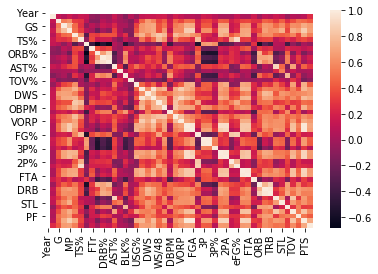

In [3]:
X1 =X.fillna(0)
corr = X1.corr()
sns.heatmap(X1.corr())

### Does position matter?

It seems we missed one small detail while preprocessing the data. Namely, the player position is a categorical data column. As it is generally thought that position matters in the salaries, we will proceed to turn it into a numerical column and then check the correlation with the salaries to see if this perception holds up!

In [4]:
X1['Pos'].unique()

array(['SG', 'PF', 'C', 'SF', 'PG', 'PF-C'], dtype=object)

In [5]:
X1 = X1.replace({'PF-C':6, 'PF': 4, 'C': 5, 'SF': 3,'SG': 2,'PG':1})

In [6]:
X1['Pos'].unique()

array([2, 4, 5, 3, 1, 6])

In [7]:
X1[['Pos', 'season17_18']].corr()

,Pos,season17_18
Pos,1.000000,0.036664
season17_18,0.036664,1.000000


It becomes clear that the position doesn't play a big role when it comes to dictating the salaries!

### Lowering the dimension of our problem based on the correlation matrix

We will first proceed to remove the columns of Team, Position and Player name as they do not play a role

In [8]:
X1.drop(['Tm', 'Pos', 'Player'], axis =1, inplace = True)
X1.columns.shape

(48,)

Now we start by manipulating our dataframe based on how much categories correlate with each other. In other words, we will eliminate one of every two categories witha correlation of more than 0.9. This makes sense as this high of a correlation basically impies one of the two categories is redundant.

In [9]:
columns = np.full((X1.corr().shape[0],), True, dtype=bool)
for i in range(X1.corr().shape[0]):
    for j in range(i+1, X1.corr().shape[0]):
        if X1.corr().iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = X1.columns[columns]
X2 = X1[selected_columns]



Following this up we will eliminate any category that has a correlation lower than 0.1 with our salaries as they have a very limited influence on the final predictions.

In [10]:
columns1 = np.full((X2.corr().shape[0],), True, dtype=bool)
for i in range(X2.corr().shape[0]-1):
    if corr.iloc[i,X2.corr().shape[0]-1] <= 0.1:
          if columns1[i]:
                columns1[i] = False
selected_columns = X2.columns[columns1]
X3 = X2[selected_columns]

In [11]:
X3.columns.shape

(30,)

We see that we managed to reduce the dimension substantially! From 48 categories to 30! Last must not forget to remove the salaries from our input data. So we will have 29 input categories.

In [12]:
X3.drop(['season17_18'],axis =1, inplace = True)

/home/jorgos/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Preparing the training and validation sets

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X3, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

As the last step, we will Rescale the datapoints in the following way: 
    a' = (a-mean)/std

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

## Testing out different Regression models

We present here the results of a number of different Machine Learning models, Namely:
- Linear Regression
- SVM with multiple kernels
- Random forest
- XGboost ensemble learning

We see that in this particular problem, one algorithm stands out. Polynomial Regression manages to obtain an error of 2 million dollars while all the other algorithms sit closer to 4 million or worse. The ensemble algorithms, such as RandomForest and XGboost, are expected to struggle to improve over the normal algorithms due to the small amount of datapoints. Still, they perform as well.

In [42]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures

### Linear Regression

In [43]:
my_reg = LinearRegression()
my_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
mean_absolute_error(y_valid, my_reg.predict(X_valid))

3983582.1881860583

### Polynomial Regression

In [45]:
poly_reg=PolynomialFeatures(degree=2)
X_poly=poly_reg.fit_transform(X_train)
X_poly_valid=poly_reg.transform(X_valid)
poly_reg.fit(X_poly,y_train)
my_reg2=LinearRegression()
my_reg2.fit(X_poly,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
mean_absolute_error(y_valid, my_reg2.predict(X_poly_valid))

21991700.918399025

### Random Forest

In [47]:
model = RandomForestRegressor(n_estimators=100, criterion ='mae', random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [48]:
mean_absolute_error(y_valid, model.predict(X_valid))

3786054.0404819273

### Support Vector machine

In [81]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1,
               coef0=1)

In [82]:
svr_rbf.fit(X_train, y_train)
svr_lin.fit(X_train, y_train)
svr_poly.fit(X_train, y_train)

SVR(C=100, cache_size=200, coef0=1, degree=2, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [83]:
[mean_absolute_error(y_valid, svr_rbf.predict(X_valid)),mean_absolute_error(y_valid, svr_lin.predict(X_valid)),mean_absolute_error(y_valid, svr_poly.predict(X_valid))
]

[6577266.352654226, 6449997.142172281, 6567252.592517597]

### XGboost Regressor

In [52]:
XGmodel = XGBRegressor()
XGmodel.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [53]:
mean_absolute_error(y_valid, XGmodel.predict(X_valid))

3943992.3972138553

## Introducing PCA dimension reduction and testing its impact on our results

Principal component analysis is a technique employed in multiple field(for example, physics and cosmology) to lower the dimension of a space by looking at the eigenvalues of the correlation matrix.  Then the eigenvalues with maximum correlation(the Principal components) are kept. This way the dimension of our data can be lowered and this will be employed here as we have a fairly high dimension of 29 categories.

We choose to keep 10 categories as our Principal Components

When reducing the dimensions to 10 we see a very slight improvement in some algorithms. In particular, Random Forest now becomes our mostr accurate algorithm. What does stand out is the worsening of the polynomial regression algorithm as it benefitted from the many categories we had earlier.

### The Principal Component algortihm 

In [54]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
X_train_1 = pca.fit_transform(X_train)
X_valid_1 = pca.transform(X_valid)
explained_variance = pca.explained_variance_ratio_

### SVM

In [55]:
from sklearn.svm import SVR

In [78]:
svr_rbf1 = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin1 = SVR(kernel='linear', C=100, gamma='auto')
svr_poly1 = SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1,
               coef0=1)

In [79]:
svr_rbf1.fit(X_train_1, y_train)
svr_lin1.fit(X_train_1, y_train)
svr_poly1.fit(X_train_1, y_train)

SVR(C=100, cache_size=200, coef0=1, degree=2, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [80]:
[mean_absolute_error(y_valid, svr_rbf1.predict(X_valid_1)),mean_absolute_error(y_valid, svr_lin1.predict(X_valid_1)),mean_absolute_error(y_valid, svr_poly1.predict(X_valid_1))
]

[6577095.205623048, 6449907.582832124, 6542192.87942587]

### Linear Regression

In [59]:
my_reg1 = LinearRegression()
my_reg1.fit(X_train_1, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [60]:
mean_absolute_error(y_valid, my_reg1.predict(X_valid_1))

3900826.3497077464

### Polynomial Regression

In [61]:
poly_reg=PolynomialFeatures(degree=2)
X_poly_1=poly_reg.fit_transform(X_train_1)
X_poly_valid_1=poly_reg.transform(X_valid_1)
poly_reg.fit(X_poly_1,y_train)
my_reg2=LinearRegression()
my_reg2.fit(X_poly_1,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
mean_absolute_error(y_valid, my_reg2.predict(X_poly_valid_1))

4533652.381180828

### Random Forest

In [63]:
model1 = RandomForestRegressor(n_estimators=100, criterion ='mae', random_state=0)
model1.fit(X_train_1, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [64]:
mean_absolute_error(y_valid, model1.predict(X_valid_1))

3791056.2607228905

### XGboost Regressor

In [65]:
XGmodel1 = XGBRegressor()
XGmodel1.fit(X_train_1, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [66]:
pred = XGmodel1.predict(X_valid_1)

In [67]:
mean_absolute_error(y_valid, pred)

3924600.2161144577